In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from pipeline.feature_extraction import FeaturesExtraction
from pathlib import Path
import time
import copy

import logging
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

In [2]:
torch.cuda.is_available()

True

### Data prep

In [3]:
data = SkinLesion_Dataset(class_task='binary',resize_image= False, process=True)
preproc = SkinLesionPreprocessing(resize=True, remove_hair=False)

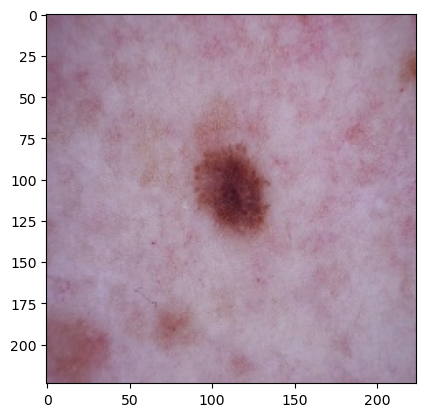

In [4]:
plt.imshow(data[0]['img'])

In [ ]:
# datasets = {
#         'train': SkinLesion_Dataset(class_task='binary', partitions=['train'], 
#                                     process=True, transforms=data_transforms['train']),
#         'val': SkinLesion_Dataset(class_task='binary', partitions=['val'],
#                                   process=True, transforms=data_transforms['val'])
#         }

# def collate_fn(batch):
#         return tuple(zip(*batch))

# dataloaders = {
#         'val': DataLoader(
#             datasets['val'], batch_size=5,
#             num_workers=4, collate_fn=collate_fn, drop_last=False),
#         'train': DataLoader(
#             datasets['train'], batch_size=2,
#             shuffle=True, collate_fn=collate_fn, num_workers=4, drop_last=False)
#     }


In [5]:
cfg = {
    'data': {
        'data_dir' : '../../data_processed/binary/',
        'chkpt_path' : '../../models/binary/',
        'best_model_path' : '../../models/binary/best_model.pt',
        'tensorboard_path' : '../../models/binary/tensorboard/',
        },
    'train': {
        'epochs' : 25,
        'batch_size' : 20,
        'lr' : 0.001,
        'momentum' : 0.9,
        'weight_decay' : 0.0005,
        'num_workers' : 4,
        'lr_step_size' : 7,
        'gamma' : 0.1,
        },
    'val': {
        'batch_size' : 5,
        'num_workers' : 4,
        }
}
       

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms['train'])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # "cpu"


In [7]:
dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False),
        'train': DataLoader(
            datasets['train'], batch_size=cfg['train']['batch_size'],
            shuffle=True, num_workers=cfg['val']['num_workers'], drop_last=False)
    }

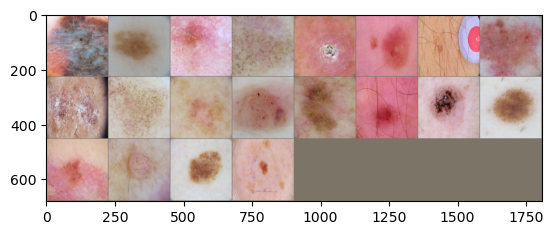

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

### Train model

In [9]:
def train_model(model, criterion, optimizer, scheduler, writer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'acc/{phase}', epoch_acc, epoch+1)
            writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path'] + f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### finetuning

In [10]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])

In [11]:
writer = SummaryWriter(cfg['data']['tensorboard_path'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/24
----------
train Loss: 0.4426 Acc: 0.7935
val Loss: 0.4187 Acc: 0.8141

Epoch 1/24
----------
train Loss: 0.3674 Acc: 0.8352
val Loss: 0.3775 Acc: 0.8297

Epoch 2/24
----------


KeyboardInterrupt: 

#### feature extractor

In [10]:
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])

In [12]:
writer = SummaryWriter(cfg['data']['tensorboard_path'])
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, writer,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/24
----------
train Loss: 0.4980 Acc: 0.7589
val Loss: 0.4310 Acc: 0.8093

Epoch 1/24
----------
train Loss: 0.4705 Acc: 0.7796
val Loss: 0.4493 Acc: 0.7956

Epoch 2/24
----------
train Loss: 0.4640 Acc: 0.7835
val Loss: 0.4515 Acc: 0.7935

Epoch 3/24
----------
train Loss: 0.4682 Acc: 0.7765
val Loss: 0.4626 Acc: 0.7821

Epoch 4/24
----------
train Loss: 0.4635 Acc: 0.7829
val Loss: 0.5449 Acc: 0.7395

Epoch 5/24
----------
train Loss: 0.4708 Acc: 0.7779
val Loss: 0.4305 Acc: 0.8014

Epoch 6/24
----------
train Loss: 0.4667 Acc: 0.7822
val Loss: 0.4341 Acc: 0.8045

Epoch 7/24
----------
train Loss: 0.4331 Acc: 0.7999
val Loss: 0.4221 Acc: 0.8061

Epoch 8/24
----------
train Loss: 0.4350 Acc: 0.7989
val Loss: 0.4211 Acc: 0.8082

Epoch 9/24
----------
train Loss: 0.4302 Acc: 0.7989
val Loss: 0.4234 Acc: 0.8080

Epoch 10/24
----------
train Loss: 0.4309 Acc: 0.8014
val Loss: 0.4245 Acc: 0.8082

Epoch 11/24
----------
train Loss: 0.4292 Acc: 0.8012
val Loss: 0.4230 Acc: 0.8072

Ep

KeyboardInterrupt: 